### Engineering features inspired by the Koppen Climate Classification system.
* More details on how each of these features are utilized in the Koppen system at [this link](http://hanschen.org/koppen)

* Will be clustering on global data first to make sure that this unsupervised approach gives similar climate clusters to this following image. 

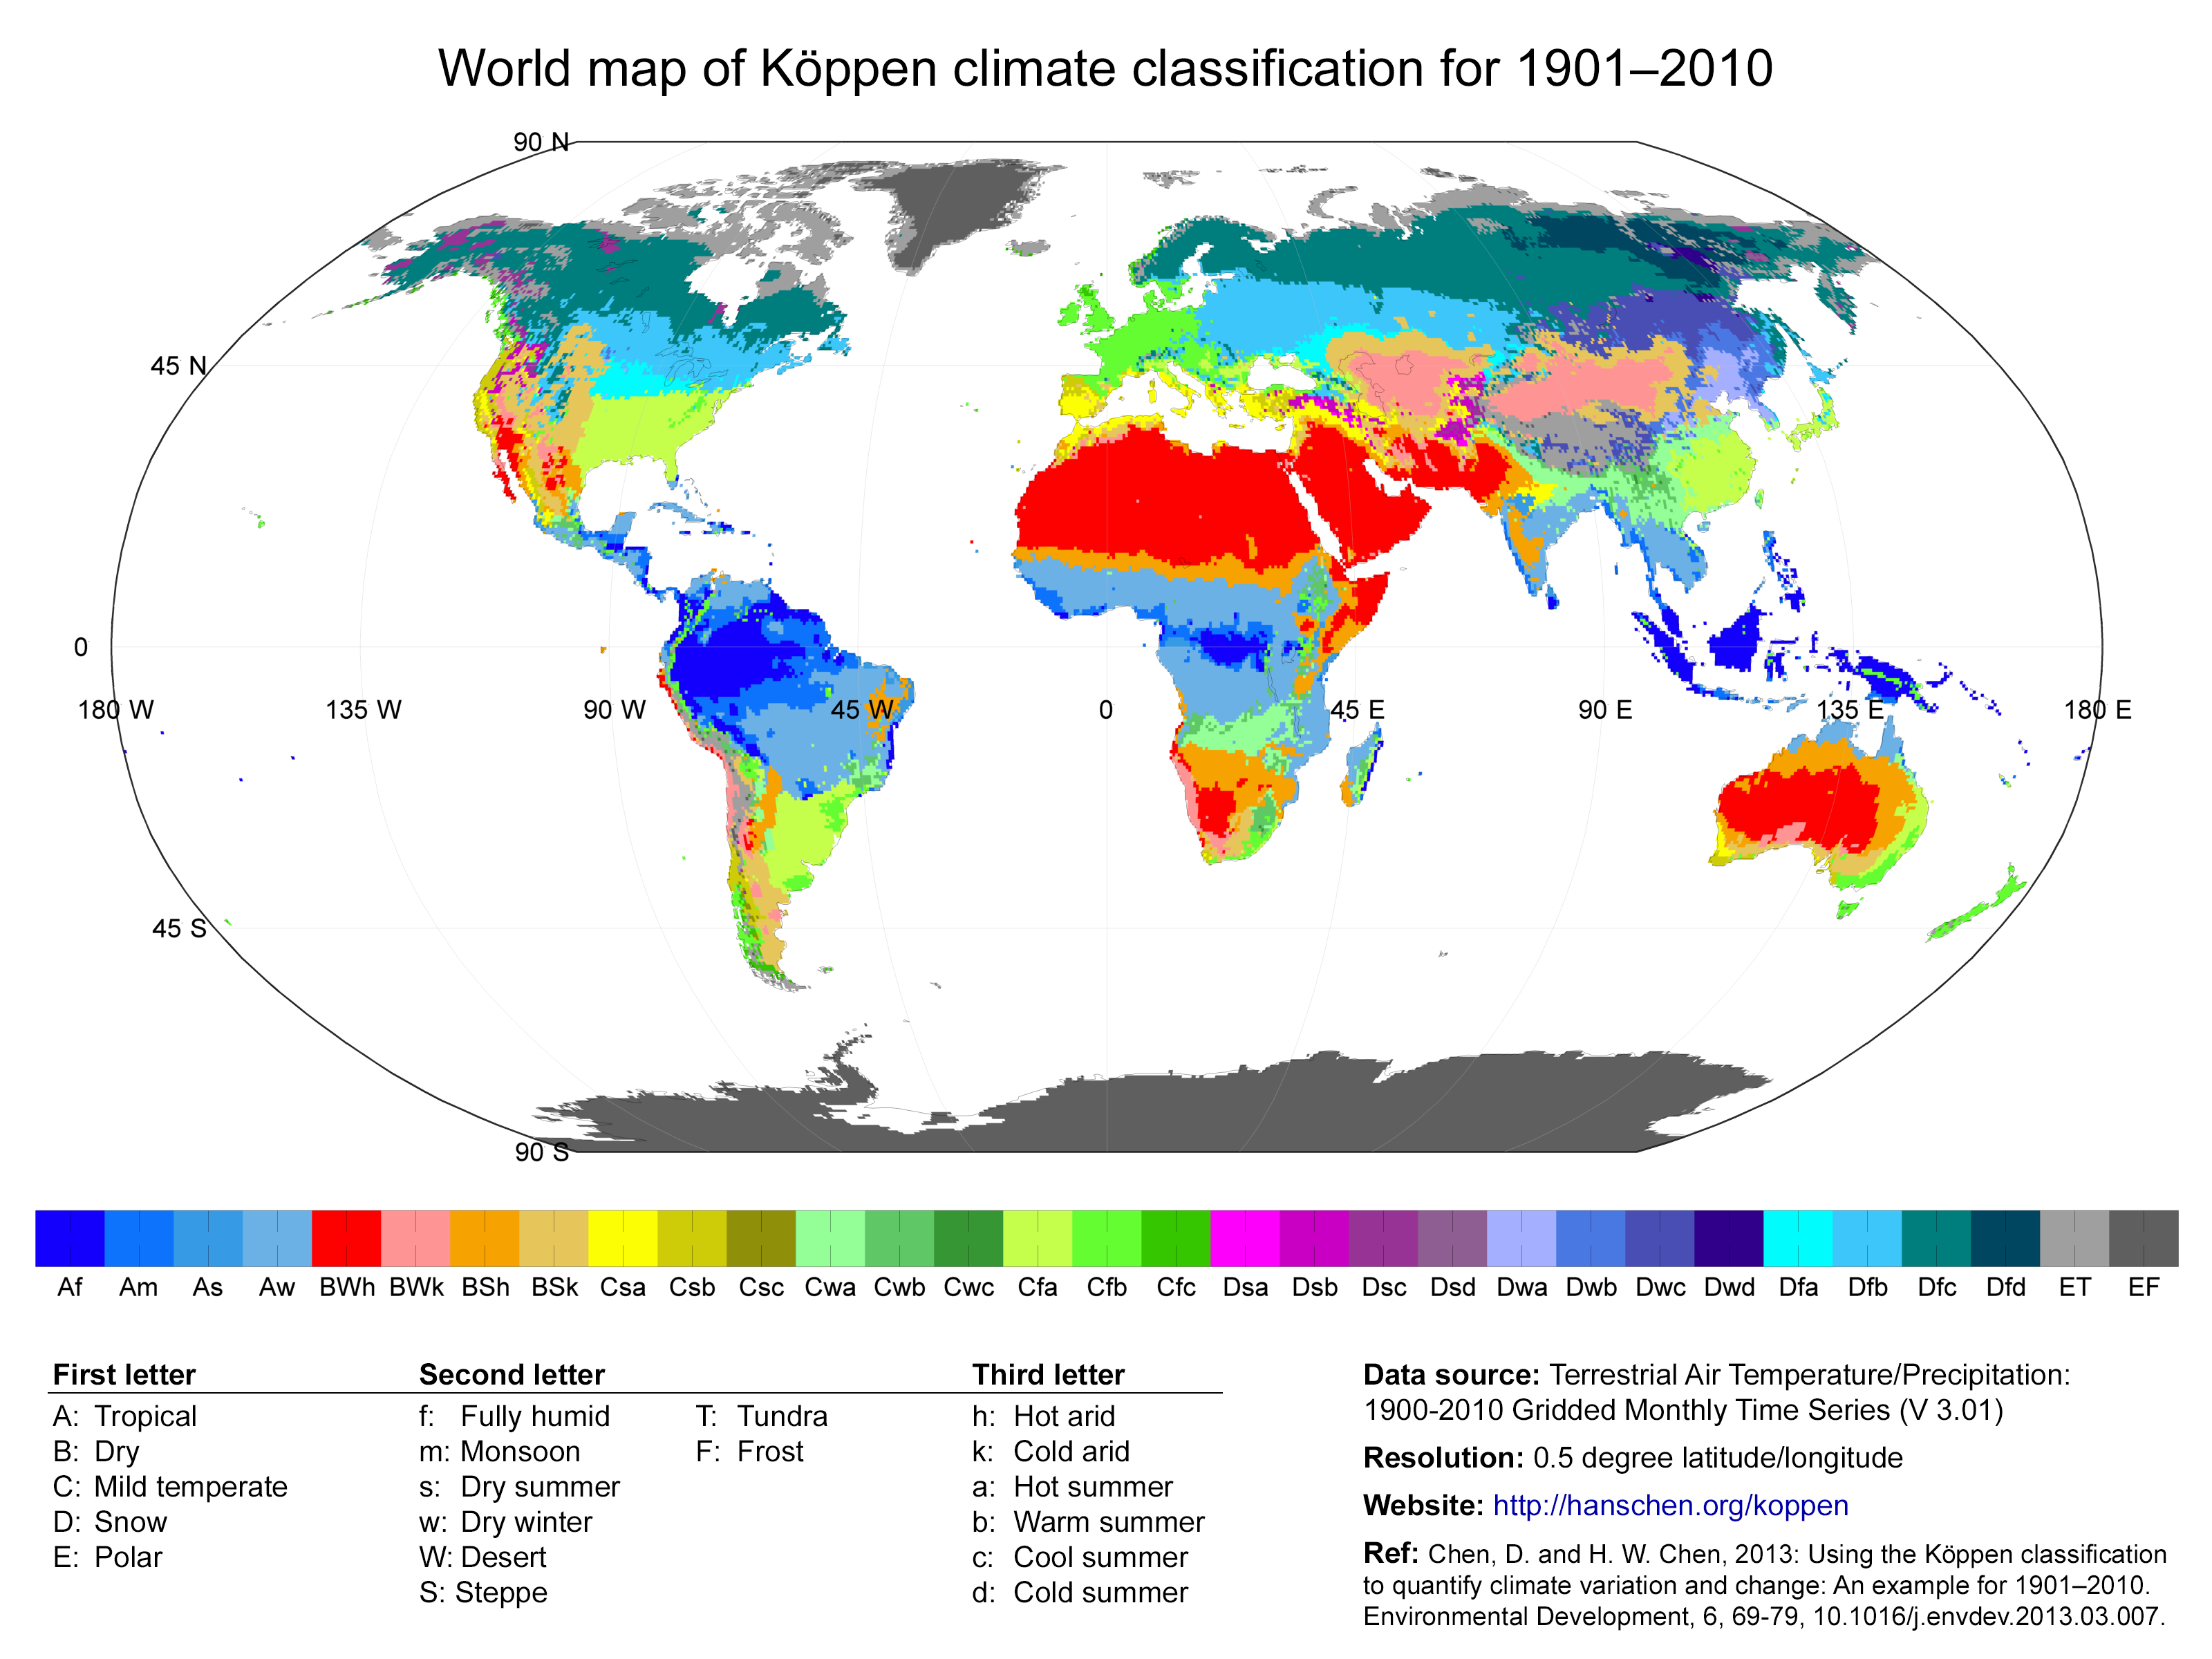

In [2]:

import xarray as xr
import dask
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt
import numpy as np

In [3]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:38179 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 50.56 GB


In [4]:
ds = xr.open_dataset('monthly_era5_2018.nc',
                     chunks={'time': -1, 'latitude': 'auto', 'longitude': 'auto'})

In [5]:
ds.t2m[0].values

array([[247.99673, 247.99673, 247.99673, ..., 247.99673, 247.99673,
        247.99673],
       [248.29007, 248.29007, 248.29007, ..., 248.29007, 248.29007,
        248.29007],
       [248.62434, 248.62434, 248.62271, ..., 248.62271, 248.62271,
        248.62434],
       ...,
       [246.11392, 246.11229, 246.11229, ..., 246.11555, 246.11555,
        246.11555],
       [246.03035, 246.02872, 246.02872, ..., 246.03035, 246.03035,
        246.03035],
       [245.83862, 245.83862, 245.83862, ..., 245.83862, 245.83862,
        245.83862]], dtype=float32)

In [6]:
#Min monthly value for whole year
annual_min = ds.min(dim='time')
annual_min = annual_min.rename({'t2m':'annual_min_t2m', 'tp':'annual_min_tp'})

In [7]:
#Max monthly value for whole year
annual_max = ds.max(dim='time')
annual_max = annual_max.rename({'t2m':'annual_max_t2m', 'tp':'annual_max_tp'})

In [8]:
#Annual mean value
annual_mean = ds.mean(dim='time')
annual_mean = annual_mean.rename({'t2m':'annual_mean_t2m', 'tp':'annual_mean_tp'})

In [9]:
north_hemi = ds.where(ds.latitude > 0, drop = True)
south_hemi = ds.where(ds.latitude <= 0, drop =  True)

def as_mask(month):
    #creates boolean mask for summer/winter months (april-sept), depending on hemisphere
    return (month >= 4) & (month <= 9)

def om_mask(month):
    #creates boolean mask for summer/winter months (oct-march), depending on hemisphere
    return (month <= 3) | (month >= 10)


In [10]:
#Min/max monthly value for summer months (april-sept) for Northern Hemi
north_hemi_summer = north_hemi.sel(time=as_mask(north_hemi['time.month']))

north_hemi_summer_min = north_hemi_summer.min(dim = 'time')
north_hemi_summer_min = north_hemi_summer_min.rename({'t2m': 'sum_min_t2m', 'tp': 'sum_min_tp'})

north_hemi_summer_max = north_hemi_summer.max(dim = 'time')
north_hemi_summer_max = north_hemi_summer_max.rename({'t2m': 'sum_max_t2m', 'tp': 'sum_max_tp'})



In [11]:
#Min/max monthly value for summer months (oct-march) for southern hemi
south_hemi_summer = south_hemi.sel(time = om_mask(south_hemi['time.month']))

south_hemi_summer_min = south_hemi_summer.min(dim = 'time')
south_hemi_summer_min = south_hemi_summer_min.rename({'t2m': 'sum_min_t2m', 'tp': 'sum_min_tp'})

south_hemi_summer_max = south_hemi_summer.max(dim = 'time')
south_hemi_summer_max = south_hemi_summer_max.rename({'t2m': 'sum_max_t2m', 'tp': 'sum_max_tp'})


In [12]:
#min/max monthly value for winter months (oct-march) for Northern hemi
north_hemi_winter = north_hemi.sel(time=om_mask(north_hemi['time.month']))

north_hemi_winter_min = north_hemi_winter.min(dim = 'time')
north_hemi_winter_min = north_hemi_winter_min.rename({'t2m': 'win_min_t2m', 'tp': 'win_min_tp'})

north_hemi_winter_max = north_hemi_winter.max(dim = 'time')
north_hemi_winter_max = north_hemi_winter_max.rename({'t2m': 'win_max_t2m', 'tp': 'win_max_tp'})


In [13]:
#min/max monthly value for winter months (april-sept) for southern hemi
south_hemi_winter = south_hemi.sel(time = as_mask(south_hemi['time.month']))

south_hemi_winter_min = south_hemi_winter.min(dim = 'time')
south_hemi_winter_min = south_hemi_winter_min.rename({'t2m': 'win_min_t2m', 'tp': 'win_min_tp'})

south_hemi_winter_max = south_hemi_winter.max(dim = 'time')
south_hemi_winter_max = south_hemi_winter_max.rename({'t2m': 'win_max_t2m', 'tp': 'win_max_tp'})


In [14]:
#mean summer months MODIFIED VARIABLE NAMES FOR TESTING
north_hemi_summer_mean = north_hemi_summer.mean(dim = 'time')
north_hemi_summer_mean = north_hemi_summer_mean.rename({'t2m': 'sum_mean_t2m', 'tp': 'sum_mean_tp'})

south_hemi_summer_mean = south_hemi_summer.mean(dim = 'time')
south_hemi_summer_mean = south_hemi_summer_mean.rename({'t2m': 'sum_mean_t2m', 'tp': 'sum_mean_tp'})


In [15]:
#mean winter months
north_hemi_winter_mean = north_hemi_winter.mean(dim = 'time')
north_hemi_winter_mean = north_hemi_winter_mean.rename({'t2m': 'win_mean_t2m', 'tp': 'win_mean_tp'})


south_hemi_winter_mean = south_hemi_winter.mean(dim = 'time')
south_hemi_winter_mean = south_hemi_winter_mean.rename({'t2m': 'win_mean_t2m', 'tp': 'win_mean_tp'})


In [16]:
summer_min = xr.combine_nested([[north_hemi_summer_min],[south_hemi_summer_min]], concat_dim=['latitude', 'longitude'])
summer_max = xr.combine_nested([[north_hemi_summer_max],[south_hemi_summer_max]], concat_dim=['latitude', 'longitude'])
summer_mean = xr.combine_nested([[north_hemi_summer_mean],[south_hemi_summer_mean]], concat_dim=['latitude', 'longitude'])

winter_min = xr.combine_nested([[north_hemi_winter_min],[south_hemi_winter_min]], concat_dim=['latitude', 'longitude'])
winter_max = xr.combine_nested([[north_hemi_winter_max],[south_hemi_winter_max]], concat_dim=['latitude', 'longitude'])
winter_mean = xr.combine_nested([[north_hemi_winter_mean],[south_hemi_winter_mean]], concat_dim=['latitude', 'longitude'])

In [17]:
# Cols: annual_min, annual_max, annual_mean, 
#       summer_min, summer_max, summer_mean, 
#       winter_min, winter_max, winter_mean

# Rows: (lat, lon) should end up being 1,038,240 rows of data (721X1440)

In [18]:
dset = xr.combine_by_coords([annual_min, annual_max, annual_mean, summer_min, summer_max, summer_mean, winter_min, winter_max, winter_mean])

In [19]:
dset

<xarray.Dataset>
Dimensions:          (latitude: 721, longitude: 1440)
Coordinates:
  * longitude        (longitude) float32 0.0 0.25 0.5 ... 359.25 359.5 359.75
  * latitude         (latitude) float32 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Data variables:
    annual_max_t2m   (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    annual_max_tp    (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    annual_mean_t2m  (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    annual_mean_tp   (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    annual_min_t2m   (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    annual_min_tp    (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    sum_max_t2m      (latitude, longitude) float32 dask.array<chunksize=(360, 1440), meta=np.ndarray>
    sum_max_tp       (latitude, longitude) float32 dask.array<chunksize=(360, 1440), meta=np.ndarray>
    sum_mean_t2m     (latitude, longitude) float32 dask.array<chunksize=(360, 1440), meta=np.ndarray>
    sum_mean_tp      (latitude, longitude) float32 dask.array<chunksize=(360, 1440), meta=np.ndarray>
    sum_min_t2m      (latitude, longitude) float32 dask.array<chunksize=(360, 1440), meta=np.ndarray>
    sum_min_tp       (latitude, longitude) float32 dask.array<chunksize=(360, 1440), meta=np.ndarray>
    win_max_t2m      (latitude, longitude) float32 dask.array<chunksize=(360, 1440), meta=np.ndarray>
    win_max_tp       (latitude, longitude) float32 dask.array<chunksize=(360, 1440), meta=np.ndarray>
    win_mean_t2m     (latitude, longitude) float32 dask.array<chunksize=(360, 1440), meta=np.ndarray>
    win_mean_tp      (latitude, longitude) float32 dask.array<chunksize=(360, 1440), meta=np.ndarray>
    win_min_t2m      (latitude, longitude) float32 dask.array<chunksize=(360, 1440), meta=np.ndarray>
    win_min_tp       (latitude, longitude) float32 dask.array<chunksize=(360, 1440), meta=np.ndarray>

In [22]:
dset.to_netcdf('era5_2018_prepared.nc')